## Line Spacing Test

How quickly do we lose information as a function of the line-spacing? Does tensor interpolation improve recovery? Find out with this notebook!

NOTE: For ease of reproducibility, we load the results from the Quaternion interpolation directly for plotting. The code for quaternion interpolation can be made available on request.

In [1]:
# Import the necessary libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cmasher as cmr
import tensorweave as tw
import random

# Set device
device = "cpu"
dtype = torch.float32
random.seed(42) # For reproducibility

In [2]:
# Plotting params (For an even prettier look!)
from matplotlib import colors
import matplotlib as mpl
import matplotlib.font_manager as font_manager

font_dirs = ['./Fonts/',]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs[0], fontext="ttf")

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# Plotting params
# RCParams
import matplotlib as mpl
mpl.rcParams["text.usetex"] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams["mathtext.fontset"] = "stixsans"
plt.rcParams["mathtext.default"] = "it"
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['font.size'] = 18
plt.rcParams["axes.formatter.limits"] = [-5, 5]

# OPTIONAL CUSTOM COLORMAP
import matplotlib.colors as mcolors

# Define the colors extracted manually from the curlew
colors = [
    "#A6340B",  # rich red (not darkest)
    "#E35B0E",  # vibrant orange-red
    "#F39C12",  # medium orange
    "#F0C419",  # bright orange-yellow
    "#FAE8B6",  # soft pale orange (close to white but not pure white)
    "#8CD9E0",  # light cyan blue
    "#31B4C2",  # medium cyan-blue
    "#1B768F",  # medium blue 
    "#054862",  # deeper blue (not darkest)
]

# Create a discrete colormap using these colors
curlew_cmap = mcolors.ListedColormap(colors)
curlew_cont = mcolors.LinearSegmentedColormap.from_list(name="curlew_cont", colors=colors)

In [3]:
# High resolution dataset
full_dataset_hr = np.load("../Datasets/synthetic_highres.npy")
# Coordinates (m)
xyz_hr = full_dataset_hr[:, (0, 1, 2)]
# Gravitational acceleration (mGal)
g_hr = full_dataset_hr[:, (3, 4, 5)]
# Gradiometry (Eotvos)
ftg_hr = full_dataset_hr[:, 6:]

# Interpolation grid from the high res dataset
xvec = xyz_hr[:, 0] # Extract x-coordinates
yvec = xyz_hr[:, 1] # Extract y-coordinates
zvec = xyz_hr[:, 2] # Extract z-coordinates
grid = np.c_[xvec, yvec, zvec] # shape: (N, 3)
actv = np.ones_like(xvec).astype(bool) # Active grid points (all points are active in this case)
shape = (65, 65) # Reshape for plotting
x_mesh = xvec.reshape(shape)[:, 0] # Reshape x-coordinates for plotting
y_mesh = yvec.reshape(shape)[0] # Reshape y-coordinates for plotting

# Preload active grid points (for Laplacian loss)
actv_points = np.c_[xvec, yvec, zvec][actv]  # shape: (N_active, 3)
actv_points_torch = torch.tensor(actv_points, device=device, dtype=dtype)

### Low Resolution Datasets

From the directory, we load the paths of ten different datasets with the corresponding locations and 6 tensor components to test our interpolator.

In [17]:
# Get the low-resolution datasets
paths_lr = ["../Datasets/synthetic_lowres_80.npy", "../Datasets/synthetic_lowres_100.npy",
            "../Datasets/synthetic_lowres_120.npy", "../Datasets/synthetic_lowres_160.npy",
            "../Datasets/synthetic_lowres_177.npy", "../Datasets/synthetic_lowres_200.npy",
            "../Datasets/synthetic_lowres_260.npy", "../Datasets/synthetic_lowres_320.npy",
            "../Datasets/synthetic_lowres_400.npy", "../Datasets/synthetic_lowres_560.npy"]
ls_lr = [80, 100, 120, 160, 177, 200, 260, 320, 400, 560]
# Initialise the lists for metrics
nf_r2 = []
nf_ss = []
nf_mse = []
# The list for models
linespacing_models = []

In [18]:
# Set different random seeds for each model
seed_list = random.sample(range(20000), k = len(paths_lr))

# Loop through the low-resolution datasets
for i in range(len(paths_lr)):
    print("Line Spacing: " + str(ls_lr[i]) + " m")
    # Low resolution dataset
    full_dataset = np.load(paths_lr[i])
    # Coordinates
    xyz = full_dataset[:, (0, 1, 2)]
    # Gravitational acceleration
    g = full_dataset[:, (3, 4, 5)]
    # Gradiometry
    ftg = full_dataset[:, 6:]
    # Add some noise to the data
    ftg = tw.add_ftg_noise_by_snr(ftg, snr_db=[20, 18, 18, 15, 17, 19])
    ftg[:, -1] = -(ftg[:, 0] + ftg[:, 3]) # Enforce tracelessness

    # Prepare the data for training
    xyz_perturb = np.copy(xyz)
    # Perturb the points in the z direction to allow model fitting
    xyz_perturb[:, 2] += (np.random.randn(xyz.shape[0]))
    # Convert to torch.tensor()
    xyz_torch = torch.tensor(xyz_perturb, device=device, dtype=dtype)
    ftg_torch = torch.tensor(ftg, device=device, dtype=dtype)  # xx, xy, xz, yy, yz, zz

    # Initialise
    model = tw.NeuralFourierField(num_fourier_features=16, length_scales=[2e2, 4e2, 1e3], learnable=True, potential_scale=5e6,
                                  device=device, hidden_layers=[256, 256], activation=nn.SiLU(), seed=seed_list[i])

    # Fit!
    losses, lapl_counts = model.fit(xyz_torch, ftg_torch, actv_points_torch, epochs=600, lr=1e-2, lap_spacing=(ls_lr[i] * 1.5, ls_lr[i] * 0.3, 6, 1, 30),
                                    lap_samples=2000, chunk_size=1024)
    
    linespacing_models.append(model)

Line Spacing: 80 m


Training:  98%|█████████▊| 590/600 [03:41<00:03,  2.66it/s, loss=7.1700, ftg=[0.907, 0.685, 1.368, 1.219, 1.291, 1.572], lap=0.129, lr=0.000225, lap_ns=2000, stall=50]        


[EarlyStopper] stop after 51 bad epochs (best at 534, value=7.18243).
Early stopping triggered.
Line Spacing: 100 m


Training: 100%|██████████| 600/600 [03:08<00:00,  3.19it/s, loss=6.6791, ftg=[0.852, 0.625, 1.237, 1.167, 1.230, 1.456], lap=0.112, lr=5.9e-5, lap_ns=1658, stall=48]    


Line Spacing: 120 m


Training:  90%|█████████ | 541/600 [02:08<00:14,  4.21it/s, loss=7.0264, ftg=[0.917, 0.647, 1.410, 1.156, 1.259, 1.540], lap=0.097, lr=3.78e-5, lap_ns=807, stall=50]       


[EarlyStopper] stop after 51 bad epochs (best at 485, value=7.02707).
Early stopping triggered.
Line Spacing: 160 m


Training: 100%|██████████| 600/600 [01:57<00:00,  5.13it/s, loss=6.6460, ftg=[0.810, 0.675, 1.269, 1.118, 1.279, 1.406], lap=0.090, lr=0.000144, lap_ns=805, stall=17]  


Line Spacing: 177 m


Training:  97%|█████████▋| 581/600 [01:56<00:03,  4.98it/s, loss=6.4429, ftg=[0.787, 0.648, 1.184, 1.150, 1.172, 1.386], lap=0.117, lr=0.000144, lap_ns=658, stall=50]     


[EarlyStopper] stop after 51 bad epochs (best at 525, value=6.45222).
Early stopping triggered.
Line Spacing: 200 m


Training:  98%|█████████▊| 586/600 [01:48<00:02,  5.38it/s, loss=6.5502, ftg=[0.824, 0.596, 1.249, 1.199, 1.100, 1.454], lap=0.128, lr=9.22e-5, lap_ns=414, stall=50]    


[EarlyStopper] stop after 51 bad epochs (best at 530, value=6.55189).
Early stopping triggered.
Line Spacing: 260 m


Training: 100%|██████████| 600/600 [01:20<00:00,  7.41it/s, loss=6.0685, ftg=[0.777, 0.613, 1.185, 1.000, 1.165, 1.222], lap=0.107, lr=0.00018, lap_ns=302, stall=0]         


Line Spacing: 320 m


Training: 100%|██████████| 600/600 [00:59<00:00, 10.05it/s, loss=6.2018, ftg=[0.777, 0.594, 1.189, 0.998, 1.239, 1.268], lap=0.135, lr=5.9e-5, lap_ns=205, stall=17]       


Line Spacing: 400 m


Training: 100%|██████████| 600/600 [00:51<00:00, 11.74it/s, loss=6.4961, ftg=[0.837, 0.459, 1.250, 1.509, 0.785, 1.556], lap=0.100, lr=5.9e-5, lap_ns=143, stall=36]        


Line Spacing: 560 m


Training: 100%|██████████| 600/600 [00:44<00:00, 13.53it/s, loss=6.3086, ftg=[0.762, 0.589, 1.170, 1.225, 1.114, 1.263], lap=0.185, lr=0.000352, lap_ns=75, stall=9]       


In [19]:
# Store the models!
torch.save(linespacing_models, "../Models/synthetic_linespacing_models_randomseeds_rtl_scaler.pkl")

In [20]:
# Evaluate over the grid!
predicted_hessians = []
xyz_linespacings = []

# Loop through the different low-resolution datasets
for i in range(len(paths_lr)):
    # Low resolution dataset
    full_dataset = np.load(paths_lr[i])
    # Coordinates
    xyz = full_dataset[:, (0, 1, 2)]
    xyz_linespacings.append(xyz)
    # Evaluate!
    pred_hessian = linespacing_models[i].predict(actv_points, output="hessian", chunk_size=2048)
    # Create an array to hold gradient components over the full grid
    hess_components = np.full((xvec.shape[0], 6), np.nan)
    hess_components[actv] = pred_hessian.reshape(-1, 9)[:, (0, 1, 2, 4, 5, 8)] # xx, xy, xz, yy, yz, zz
    predicted_hessians.append(hess_components)

In [21]:
# Setup the same experiment with RBF interpolators
from scipy.interpolate import RBFInterpolator as RBF
# Loop through the different low-resolution datasets
rbf_hessians = []
for i in range(len(paths_lr)):
    print("Interpolating line spacing: " + str(ls_lr[i]) + " m")
    # Low resolution dataset
    full_dataset = np.load(paths_lr[i])
    # Coordinates
    xyz = full_dataset[:, (0, 1, 2)]
    # Gravitational acceleration
    g = full_dataset[:, (3, 4, 5)]
    # Gradiometry
    ftg = full_dataset[:, 6:]
    # Add some noise to the data
    ftg = tw.add_ftg_noise_by_snr(ftg, snr_db=[20, 18, 18, 15, 17, 19])
    ftg[:, -1] = -(ftg[:, 0] + ftg[:, 3]) # Enforce tracelessness

    # Initialise the RBF
    rbf_func = RBF(xyz[:, :-1], ftg, neighbors=250, smoothing=1e4)
    rbf_grid = np.full((xvec.shape[0], 6), np.nan)
    # Evaluate
    rbf_grid[actv] = rbf_func(grid[actv, :-1])
    rbf_grid[:, -1] = -(rbf_grid[:, 0] + rbf_grid[:, 3])
    rbf_hessians.append(rbf_grid)


Interpolating line spacing: 80 m
Interpolating line spacing: 100 m
Interpolating line spacing: 120 m
Interpolating line spacing: 160 m
Interpolating line spacing: 177 m
Interpolating line spacing: 200 m
Interpolating line spacing: 260 m
Interpolating line spacing: 320 m
Interpolating line spacing: 400 m
Interpolating line spacing: 560 m


In [22]:
# Accuracy metrics
from sklearn.metrics import r2_score, mean_squared_error
from skimage.metrics import structural_similarity as ssim

# Compute the metrics per component
nf_r2, rbf_r2 = [], []
nf_ss, rbf_ss = [], []
nf_mse, rbf_mse = [], []

for i in range (len(predicted_hessians)):
    # Get the current spacings
    current_spacing_nf = predicted_hessians[i]
    current_spacing_rbf = rbf_hessians[i]

    # R2 Score
    rbf_r2.append(np.array([r2_score(ftg_hr[:, k], current_spacing_rbf[:, k]) for k in range(5)]))
    nf_r2.append(np.array([r2_score(ftg_hr[:, k], current_spacing_nf[:, k]) for k in range(5)]))

    # SSIM
    rbf_ss.append(np.array([ssim(ftg_hr[:, k].reshape(shape).T, current_spacing_rbf[:, k].reshape(shape).T, data_range=1) for k in range(5)]))
    nf_ss.append(np.array([ssim(ftg_hr[:, k].reshape(shape).T, current_spacing_nf[:, k].reshape(shape).T, data_range=1) for k in range(5)]))

    # MSE
    rbf_mse.append(np.array([mean_squared_error(ftg_hr[:, k], current_spacing_rbf[:, k]) for k in range(5)]))
    nf_mse.append(np.array([mean_squared_error(ftg_hr[:, k], current_spacing_nf[:, k]) for k in range(5)]))

In [23]:
# Load the quaternion scores
quaternion_scores = np.load("../Datasets/quaternion_scores.npy")
quat_r2 = quaternion_scores[0][:, :-1]
quat_ss = quaternion_scores[1][:, :-1]
quat_mse = quaternion_scores[2][:, :-1]

In [24]:
# Normalise the R2 Scores (across components)
normalised_rbf_r2 = np.linalg.norm(np.array(rbf_r2), axis=1)/np.sqrt(5)
normalised_quat_r2 = np.linalg.norm(np.array(quat_r2), axis=1)/np.sqrt(5)
normalised_nf_r2 = np.linalg.norm(np.array(nf_r2), axis=1)/np.sqrt(5)
# Do the same for SSIM
normalised_rbf_ss = np.linalg.norm(np.array(rbf_ss), axis=1)/np.sqrt(5)
normalised_quat_ss = np.linalg.norm(np.array(quat_ss), axis=1)/np.sqrt(5)
normalised_nf_ss = np.linalg.norm(np.array(nf_ss), axis=1)/np.sqrt(5)
# And the MSE
normalised_rbf_mse = np.linalg.norm(np.array(rbf_mse), axis=1)/np.sqrt(5)
normalised_quat_mse = np.linalg.norm(np.array(quat_mse), axis=1)/np.sqrt(5)
normalised_nf_mse = np.linalg.norm(np.array(nf_mse), axis=1)/np.sqrt(5)

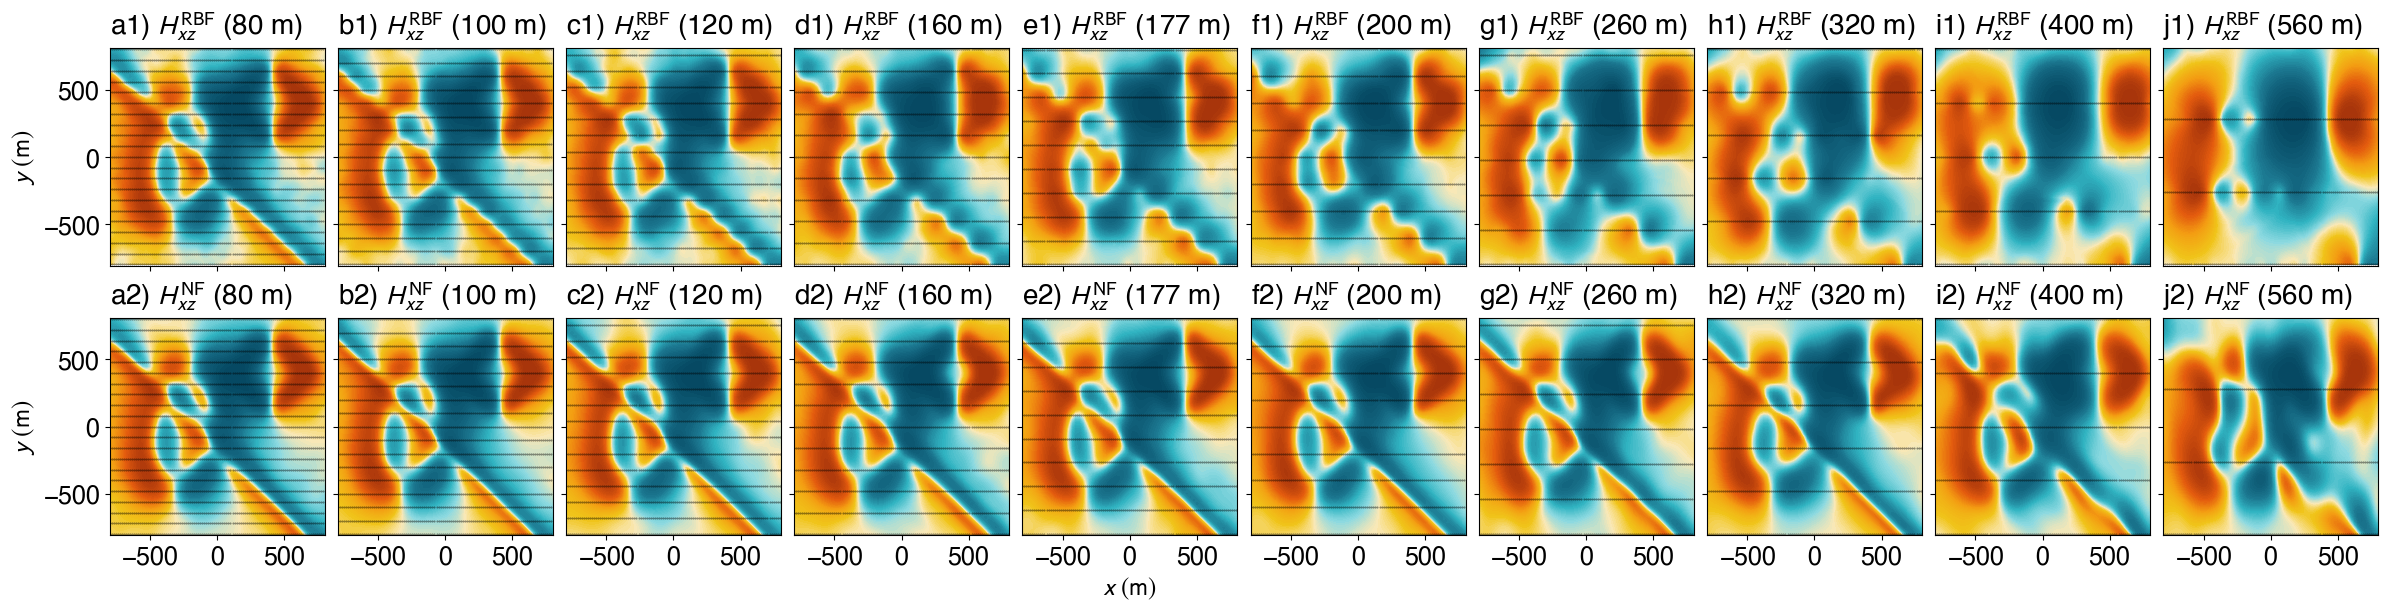

In [25]:
# Plotting indices and parameters
# Select indices corresponding to H_xy for display (adjust if needed)
idx = 2 # xz component
# Labels for NF
labels = ["a1) ", "b1) ", "c1) ", "d1) ", "e1) ", "f1) ", "g1) ", "h1) ", "i1) ", "j1) ",
          "a2) ", "b2) ", "c2) ", "d2) ", "e2) ", "f2) ", "g2) ", "h2) ", "i2) ", "j2) "]
nf_labels = [r"$H^{\mathrm{NF}}_{xx}$", r"$H^{\mathrm{NF}}_{xy}$", r"$H^{\mathrm{NF}}_{xz}$",
             r"$H^{\mathrm{NF}}_{yy}$", r"$H^{\mathrm{NF}}_{yz}$", r"$H^{\mathrm{NF}}_{zz}$"]
rbf_labels = [r"$H^{\mathrm{RBF}}_{xx}$", r"$H^{\mathrm{RBF}}_{xy}$", r"$H^{\mathrm{RBF}}_{xz}$",
              r"$H^{\mathrm{RBF}}_{yy}$", r"$H^{\mathrm{RBF}}_{yz}$", r"$H^{\mathrm{RBF}}_{zz}$"]
# Colormap capping
cmax = 15

# Plot the RBF and NF!
fig, ax = plt.subplots(2, int(len(paths_lr)), figsize=(24, 6), layout="compressed", sharex=True, sharey=True)
ax = ax.ravel()

# Contour plots
for i in range(len(paths_lr) * 2):
    if i < 10:
        j = int(i)
        ax[i].contourf(
            x_mesh, y_mesh, tw.hist_equalize(rbf_hessians[j][:, idx].reshape(shape)).T,
            levels=np.linspace(0, 1, 100),
            extend="both", cmap=curlew_cont
        )
        ax[i].set_title(labels[i] + rbf_labels[idx] + " (" + str(ls_lr[j]) + " m)", pad=10, loc="left")
        ax[i].scatter(xyz_linespacings[j][:, 0], xyz_linespacings[j][:, 1], s=0.2, c='k', alpha=0.5)
        ax[i].set_ylim([-810, 810])
    else:
        j = int(i - 10) 
        ax[i].contourf(
            x_mesh, y_mesh, tw.hist_equalize(predicted_hessians[j][:, idx].reshape(shape)).T,
            levels=np.linspace(0, 1, 100),
            extend="both", cmap=curlew_cont
        )
        ax[i].set_title(labels[i] + nf_labels[idx] + " (" + str(ls_lr[j]) + " m)", pad=10, loc="left")
        ax[i].scatter(xyz_linespacings[j][:, 0], xyz_linespacings[j][:, 1], s=0.2, c='k', alpha=0.5)
        ax[i].set_ylim([-810, 810])

# Axis labels and aspect ratio
ax[0].set_ylabel(r"$y\ (\mathrm{m})$")
ax[10].set_ylabel(r"$y\ (\mathrm{m})$")
ax[14].set_xlabel(r"$x\ (\mathrm{m})$")
for a in ax:
    a.set_aspect("equal")

plt.savefig("./Figures/appendix_synthetic_linespacing_test.png", dpi=350)
plt.show()

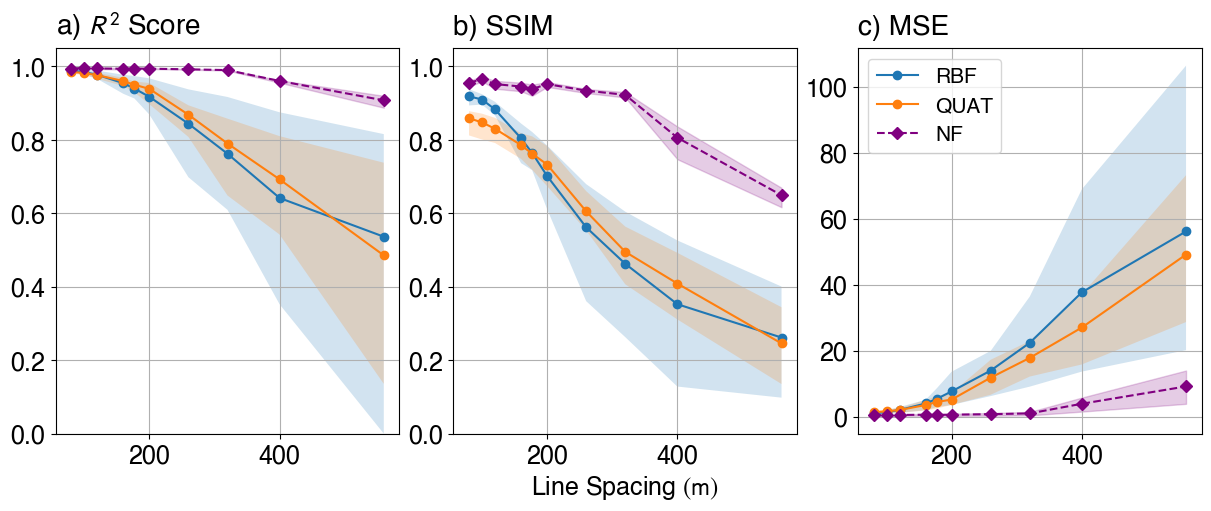

In [26]:
# Plot the scores v/s line spacing!
fig, ax = plt.subplots(1, 3, figsize=(12, 5), layout="constrained")

# R2
ax[0].plot(ls_lr, normalised_rbf_r2, marker="o", label="RBF")
ax[0].fill_between(ls_lr, np.array(rbf_r2).min(axis=1), np.array(rbf_r2).max(axis=1), alpha=0.2)
ax[0].plot(ls_lr, normalised_quat_r2, marker="o", label="QUAT")
ax[0].fill_between(ls_lr, np.array(quat_r2).min(axis=1), np.array(quat_r2).max(axis=1), alpha=0.2)
ax[0].plot(ls_lr, normalised_nf_r2, marker="D", linestyle="dashed", label="NF", c="purple")
ax[0].fill_between(ls_lr, np.array(nf_r2).min(axis=1), np.array(nf_r2).max(axis=1), color="purple", alpha=0.2)
ax[0].grid(True)
ax[0].set_title(r"a) $R^2$ Score", loc="left", pad=10)
ax[0].set_ylim([0, 1.05])

# SSIM
ax[1].plot(ls_lr, normalised_rbf_ss, marker="o", label="RBF")
ax[1].fill_between(ls_lr, np.array(rbf_ss).min(axis=1), np.array(rbf_ss).max(axis=1), alpha=0.2)
ax[1].plot(ls_lr, normalised_quat_ss, marker="o", label="QUAT")
ax[1].fill_between(ls_lr, np.array(quat_ss).min(axis=1), np.array(quat_ss).max(axis=1), alpha=0.2)
ax[1].plot(ls_lr, normalised_nf_ss, marker="D", linestyle="dashed", label="NF", c="purple")
ax[1].fill_between(ls_lr, np.array(nf_ss).min(axis=1), np.array(nf_ss).max(axis=1), color="purple", alpha=0.2)
ax[1].grid(True)
ax[1].set_title(r"b) SSIM", loc="left", pad=10)
ax[1].set_ylim([0, 1.05])
ax[1].set_xlabel(r"Line Spacing $(\mathrm{m})$")

# MSE
ax[2].plot(ls_lr, normalised_rbf_mse, marker="o", label="RBF")
ax[2].fill_between(ls_lr, np.array(rbf_mse).min(axis=1), np.array(rbf_mse).max(axis=1), alpha=0.2)
ax[2].plot(ls_lr, normalised_quat_mse, marker="o", label="QUAT")
ax[2].fill_between(ls_lr, np.array(quat_mse).min(axis=1), np.array(quat_mse).max(axis=1), alpha=0.2)
ax[2].plot(ls_lr, normalised_nf_mse, marker="D", linestyle="dashed", label="NF", c="purple")
ax[2].fill_between(ls_lr, np.array(nf_mse).min(axis=1), np.array(nf_mse).max(axis=1), color="purple", alpha=0.2)
ax[2].grid(True)
ax[2].set_title(r"c) MSE", loc="left", pad=10)

ax[2].legend(fontsize=15, loc="upper left")

plt.savefig("./Figures/line_spacing_metrics.png", dpi=350)
plt.show()

In [33]:
# Print the metrics for the RBF
print(normalised_rbf_r2)
print(normalised_rbf_ss)

[0.98901324 0.98478251 0.97726125 0.9544439  0.93994414 0.9173565
 0.84409917 0.76234933 0.64189068 0.53650585]
[0.91878849 0.91000175 0.88300048 0.80430681 0.76449591 0.70177549
 0.56202405 0.46266641 0.35269274 0.26184892]


In [34]:
# Print the metrics for the NF
print(normalised_nf_r2)
print(normalised_nf_ss)

[0.99395241 0.99660644 0.99461409 0.99378895 0.99440863 0.99393987
 0.99232638 0.99015296 0.96054426 0.9078302 ]
[0.95520196 0.96591079 0.95210359 0.94537506 0.93862761 0.95188782
 0.93433483 0.92269158 0.80614141 0.64943338]
